In [1]:
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from structures_store import h5_load_structure

colors = ['#bf4e30', '#0d3b66', '#0e9595', '#c2c1c2', '#dbad6a']

In [2]:
uniprots = pd.read_csv("datasets/selected_alphafold_models.csv").query("selected > 0.5")['uniprot'].values

structures = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    #for uniprot in tqdm(hf.keys()):
    for uniprot in tqdm(uniprots):
        structures[uniprot] = h5_load_structure(hf[uniprot])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:29<00:00, 254.47it/s]


In [3]:
# clustered interfaces
multi_interfaces_dict = json.load(open("datasets/clustered_multi_interfaces.json", 'r'))

In [4]:
# parameters
p_thr = 0.8
labels_map = {"protein":"p0", "dna/rna":"p1", "ion":"p2", "ligand":"p3", "lipid":"p4"}
itypes_sel = ["protein", "dna/rna", "ion", "ligand", "lipid"]

# select quality interfaces only
multi_interfaces_quality_dict = {}
for uniprot in tqdm(structures):
    multi_interfaces_quality_dict[uniprot] = {itype:[] for itype in multi_interfaces_dict[uniprot]}
    for itype in multi_interfaces_dict[uniprot]:
        if itype in itypes_sel:
            for ids_int in multi_interfaces_dict[uniprot][itype]:
                p = np.stack([structures[uniprot][labels_map[it]][ids_int] for it in itype.split('+')], axis=1)
                if np.all(np.mean(p, axis=0) > p_thr):
                    multi_interfaces_quality_dict[uniprot][itype].append(ids_int)
        else:
            multi_interfaces_quality_dict[uniprot][itype] = multi_interfaces_dict[uniprot][itype]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:01<00:00, 4143.08it/s]


In [5]:
del multi_interfaces_dict

In [6]:
# parameters
org_sel = "HUMAN"

sasa_dict = {}
with h5py.File("datasets/models.h5", 'r') as hf0:
    with h5py.File("datasets/solvent_accessible_surface_area.h5", 'r') as hf1:
        for uniprot in tqdm(hf1[org_sel].keys()):
            key = '{}/{}/F1'.format(org_sel, uniprot)
            resids = h5_load_structure(hf0[key])['resid']
            sasa = np.array(hf1[key]).astype(np.float32)
            sasa_dict[uniprot] = np.array([np.sum(sasa*(i == resids).astype(np.float32)) for i in np.unique(resids)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20504/20504 [03:43<00:00, 91.57it/s]


## Interfaces surfaces

In [7]:
total_surfaces = []
interfaces_surfaces = {}
relative_interfaces_size = {}
for uniprot in tqdm(list(structures)):
    sasa = sasa_dict[uniprot]
    total_surfaces.append(np.sum(sasa))
    if uniprot in multi_interfaces_quality_dict:
        interfaces = multi_interfaces_quality_dict[uniprot]
        #interfaces = multi_interfaces_dict[uniprot]
        for itype in interfaces:
            if itype in interfaces_surfaces:
                interfaces_surfaces[itype].extend([np.sum(sasa[ids]) for ids in interfaces[itype]])
                relative_interfaces_size[itype].extend([np.sum(sasa[ids])/np.sum(sasa) for ids in interfaces[itype]])
            else:
                interfaces_surfaces[itype] = [np.sum(sasa[ids]) for ids in interfaces[itype]]
                relative_interfaces_size[itype] = [np.sum(sasa[ids])/np.sum(sasa) for ids in interfaces[itype]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:00<00:00, 10124.83it/s]


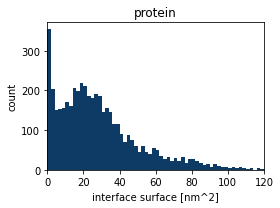

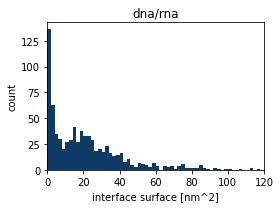

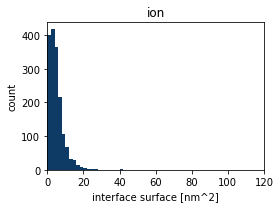

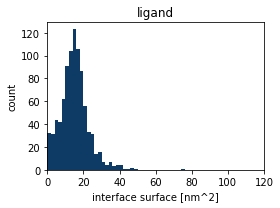

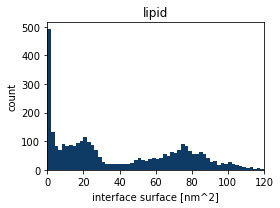

In [38]:
labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
for itype in labels:
    sasa = np.array(interfaces_surfaces[itype])

    vmax = np.quantile(sasa, 0.99)
    #vmax = np.max(sasa)
    vmax = 120
    
    plt.figure(figsize=(4,3))
    plt.hist(sasa, bins=60, range=(0.0, vmax), color=colors[1])
    plt.title(itype)
    plt.xlim(0.0, vmax)
    plt.xlabel("interface surface [nm^2]")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig("results/interface_surface_{}.png".format(itype.replace('/','')), dpi=300)
    plt.savefig("results/interface_surface_{}.svg".format(itype.replace('/','')))
    plt.show()

In [41]:
labels = ["protein", "dna/rna", "ion", "ligand"]
for itype in labels:
    sasa = np.array(interfaces_surfaces[itype])
    sasa = sasa[sasa > 3]

    print("{: <8} {:.1f} {:.1f} {:.1f}".format(itype, np.mean(sasa), np.median(sasa), np.std(sasa)))

itype = "lipid"
sasa = np.array(interfaces_surfaces[itype])
sasa = sasa[sasa > 3]
sasa_sel = sasa[sasa < 40]
print("{: <8} {:.1f} {:.1f} {:.1f}".format(itype, np.mean(sasa_sel), np.median(sasa_sel), np.std(sasa_sel)))
sasa_sel = sasa[sasa > 40]
print("{: <8} {:.1f} {:.1f} {:.1f}".format(itype, np.mean(sasa_sel), np.median(sasa_sel), np.std(sasa_sel)))

protein  31.7 26.5 22.4
dna/rna  28.8 22.6 23.5
ion      6.8 5.8 3.8
ligand   15.8 14.9 7.4
lipid    17.7 17.7 8.9
lipid    75.4 75.0 18.6
